# Stock Price Prediction using GRU

This notebook is created to compare the performance with the notebook using Ensemble Learning and Transfer Learning method.

## Import Dependencies

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Mount the data file from Google Drive

In [21]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# read the raw data
file_path = '/content/drive/MyDrive/Swinburne/COS30018_IntelligentSystem/COS30018_GroupAssignment/SharedNotebooks/group2_code_submission/data/raw/Google_20120101_to_20241212.csv'
df = pd.read_csv(file_path)

In [23]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

In [24]:
# preview the data
df

,Close,High,Low,Open,Volume
Date,,,,,
2012-01-03,16.591755,16.660076,16.266609,16.280821,146912940
2012-01-04,16.663319,16.712440,16.472319,16.582279,114445440
2012-01-05,16.432173,16.555849,16.362855,16.509970,131184684
2012-01-06,16.208012,16.456860,16.202276,16.435664,107608284
2012-01-09,15.520813,16.132709,15.490143,16.120242,232671096
...,...,...,...,...,...
2024-12-05,172.442368,175.858451,172.132725,175.159255,21356200
2024-12-06,174.510010,174.879581,171.663266,171.833070,21462400
2024-12-09,175.369995,176.259995,173.649994,173.960007,25389600


In [25]:
df.describe()

,Close,High,Low,Open,Volume
count,3257.000000,3257.000000,3257.000000,3257.000000,3.257000e+03
mean,68.038826,68.717970,67.323820,68.010498,4.562432e+07
std,45.412476,45.902598,44.905266,45.383147,3.376028e+07
min,13.939707,14.076099,13.876622,13.971874,9.312000e+06
25%,29.226553,29.400919,29.014820,29.268400,2.638200e+07
50%,54.102875,54.796360,53.496071,54.148710,3.436400e+07
75%,103.394684,104.546507,101.980309,102.847172,5.254800e+07
max,195.399994,195.610001,188.563382,189.840223,4.971983e+08


In [26]:
# check null value
df.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


### Visualise the Close price

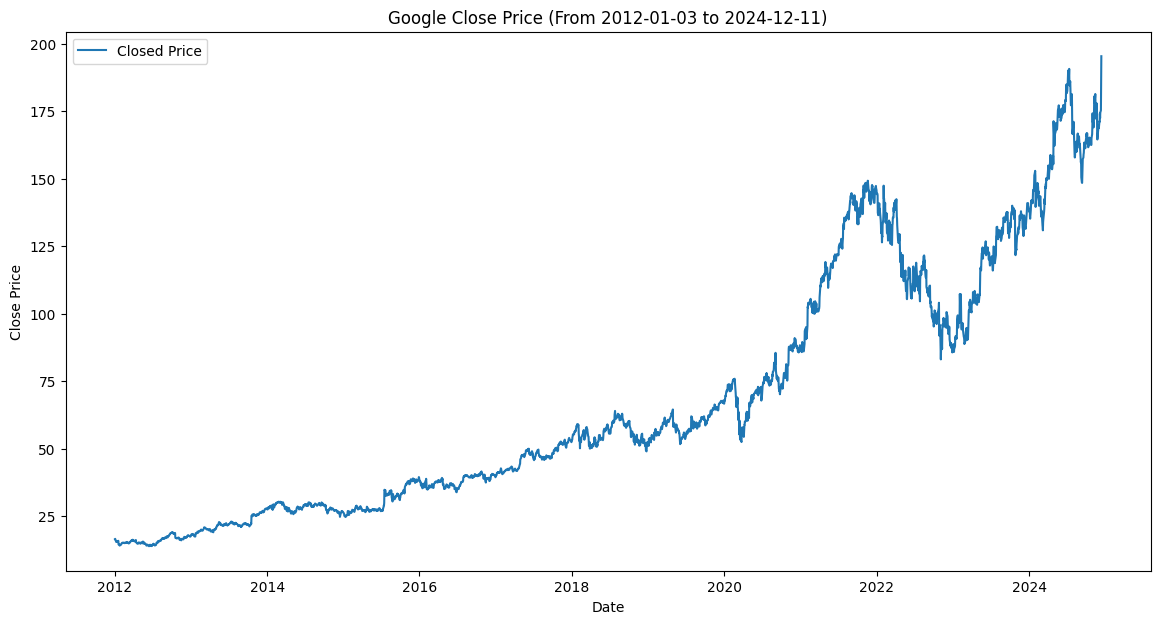

In [27]:
# Extract the company name from the filename for the Dynamic Title of the chart
company_name = file_path.split('/')[-1].split('_')[0]

# Plotting the Close price
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label = 'Closed Price')

# Dynamic Title
start_date = df.index.min().strftime('%Y-%m-%d')
end_date = df.index.max().strftime('%Y-%m-%d')
plt.title(f'{company_name} Close Price (From {start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(False)
plt.legend()
plt.show()

## Data Preprocessing

In [28]:
# Normalize the all columns in dataframe using min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [29]:
def split_data_by_date(close_price=None, split_date=None, analyzing_duration=None):
    """
    Description:
    - Split time series data into training and testing sets based on a specified split date.

    Parameters:
    - close_price (numpy.ndarray): Time series data of closing prices.
    - dates (numpy.ndarray or pandas.Series): Corresponding dates for the time series data.
    - split_date (str): The date at which to split the data ('YYYY-MM-DD').
    - analyzing_duration (int): Duration of the sequence used for prediction.

    Returns:
    - tuple: Tuple containing training and testing sets (train_X, train_y, test_X, test_y).
      - train_X (numpy.ndarray): Training input sequences.
      - train_y (numpy.ndarray): Training output values.
      - test_X (numpy.ndarray): Testing input sequences.
      - test_y (numpy.ndarray): Testing output values.
    """
    # Convert split_date to a datetime object
    split_date = pd.to_datetime(split_date)

    # Find the index where the date is greater than or equal to split_date
    split_index = np.where(df.index >= split_date)[0][0]

    # Initialize lists to store training and testing data
    train_X, train_y = [], []
    test_X, test_y = [], []

    # Generate training sequences (before split date)
    for idx in range(split_index - analyzing_duration):
        train_X.append(close_price[idx: analyzing_duration + idx].reshape(analyzing_duration))
        train_y.append(close_price[idx + analyzing_duration])

    # Reshape training data into the required format
    train_X, train_y = np.asarray(train_X).reshape((len(train_X), analyzing_duration, 1)), np.asarray(train_y)

    # Generate testing sequences (after split date)
    for idx in range(split_index - analyzing_duration, len(close_price) - analyzing_duration):
        test_X.append(close_price[idx: analyzing_duration + idx].reshape(analyzing_duration))
        test_y.append(close_price[idx + analyzing_duration])

    # Reshape testing data into the required format
    test_X, test_y = np.asarray(test_X).reshape((len(test_X), analyzing_duration, 1)), np.asarray(test_y)

    return train_X, train_y, test_X, test_y

In [30]:
split_date = '2024-01-01'
analyzing_duration = 6

# split train and test set based on specific date
X_train, y_train, X_test, y_test = split_data_by_date(close_price, split_date, analyzing_duration)

# validation split from the training data
validation_split_percentage = 0.2
train_len = len(X_train)
X_val, y_val = X_train[int(train_len - (validation_split_percentage * train_len)):], y_train[int(train_len - (validation_split_percentage * train_len)):]
X_train, y_train = X_train[:int(train_len - (validation_split_percentage * train_len))], y_train[:int(train_len - (validation_split_percentage * train_len))]

## Model

In [31]:
def gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

model = gru_model((X_train.shape[1], 1))
model.summary()
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_absolute_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, epochs=25, batch_size=150,
                        validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 6, 50)               │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 6, 50)               │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 6, 50)               │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1351
Epoch 1: val_loss improved from inf to 0.41088, saving model to best_gru_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.1334 - val_loss: 0.4109
Epoch 2/25
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1110
Epoch 2: val_loss improved from 0.41088 to 0.33246, saving model to best_gru_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1108 - val_loss: 0.3325
Epoch 3/25
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0922
Epoch 3: val_loss did not improve from 0.33246
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0920 - val_loss: 0.3645
Epoch 4/25
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0773
Epoch 4: val_loss improved from 0.33246 to 0.27853, saving model to best_gru_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0766 - val_loss: 0.2785
Epoch 5/25
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0626
Epoch 5: val_loss improved from 0.27853 to 0.08735, saving mod

## Evaluate the Model

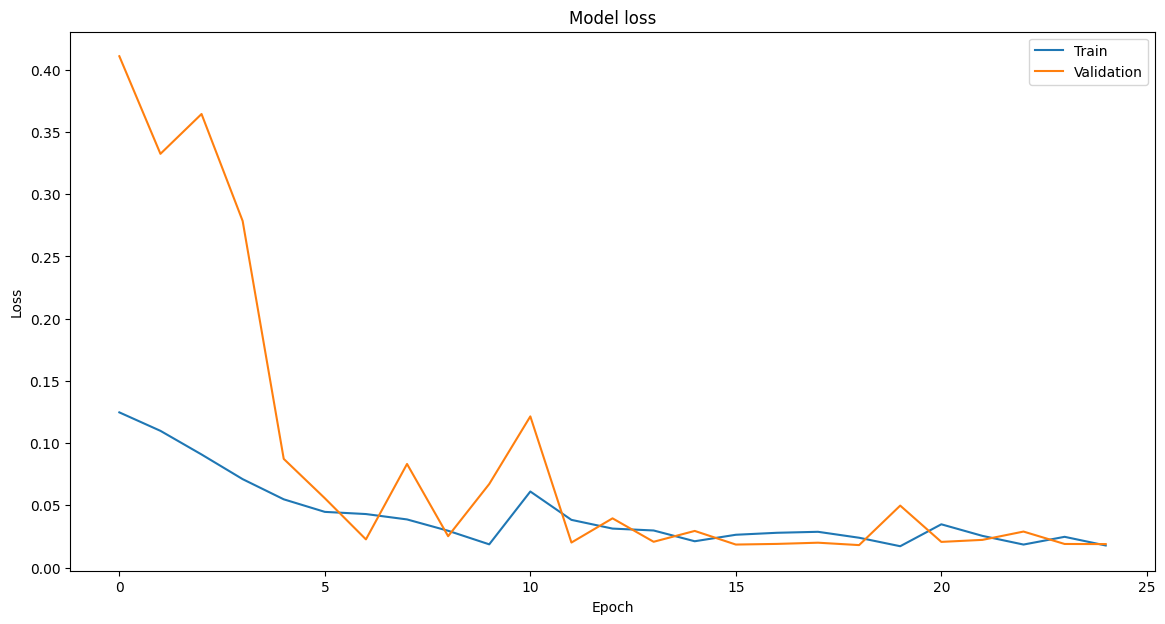

In [32]:
# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [33]:
# Make predictions
GRU_predicted_price = model.predict(X_test)

# Denormalize the predictions and actual values
GRU_predicted_price = scaler.inverse_transform(GRU_predicted_price)
denorm_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


In [34]:
# Calculate MAE, RMSE, MAPE using numpy
mae = np.mean(np.abs(denorm_y_test - GRU_predicted_price))
rmse = np.sqrt(np.mean((denorm_y_test - GRU_predicted_price)**2))
mape = np.mean(np.abs((denorm_y_test - GRU_predicted_price) / denorm_y_test)) * 100

# Create a df table to display metrics
data = {'MAE': [f'{mae:.2f}'],
        'RMSE': [f'{rmse:.2f}'],
        'MAPE': [f'{mape:.2f}%']}
df_metrics = pd.DataFrame(data, index=['GRU'])
df_metrics


,MAE,RMSE,MAPE
GRU,5.30,6.32,3.22%


## Plot the Prediction

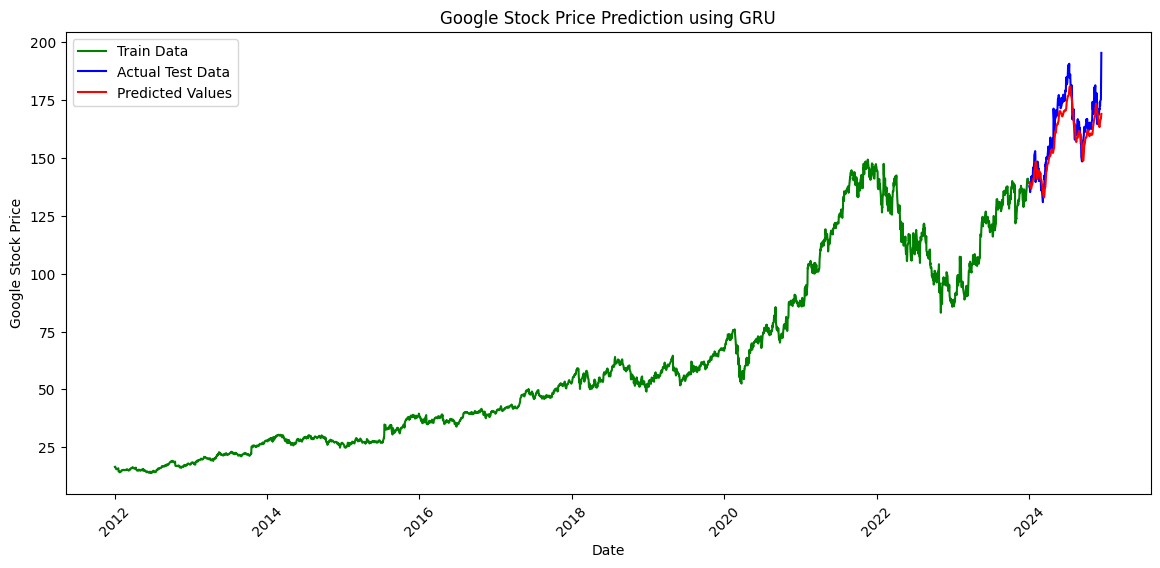

In [44]:
# Plot prediction from GRU_model

# Get the date range for the x-axis
date_range = df.index[len(df) - len(denorm_y_test):]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df.index[:len(df) - len(denorm_y_test)], df['Close'][:len(df) - len(denorm_y_test)],
         color='green', label='Train Data')
plt.plot(date_range, denorm_y_test, color='blue', label='Actual Test Data')
plt.plot(date_range, GRU_predicted_price, color='red', label='Predicted Values')

# Formatting the plot
plt.title(f'{company_name} Stock Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel(f'{company_name} Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# References

Acer, Z. (2024). *DJIA stock prediction: LSTM, GRU, and RNN models* [Kaggle notebook]. https://www.kaggle.com/code/zehraatlgan/djia-stock-prediction-lstm-gru-and-rnn-models#Building-and-Evaluating-the-LSTM-Model